In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
# %matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
import pandas as pd
import numpy as np
import os
from glob import glob

dir_path = 'calce_dataset/'
folder_cs2_35 = "CS2_35"
folder_cs2_36 = "CS2_36"
# Get all files
cs2_35_files = sorted(glob(os.path.join(dir_path, "CS2_35", "CS2_35_*.xlsx")))
cs2_36_files = sorted(glob(os.path.join(dir_path, "CS2_36", "CS2_36_*.xlsx")))


def load_discharge_data(files):
    discharge_data = []
    
    for file in files:
        try:
            df = pd.read_excel(file, sheet_name=1)
            print(f'Loading {file}...')
            cycles = list(set(df['Cycle_Index']))

            for c in cycles:
                df_lim = df[df['Cycle_Index'] == c]
                df_d = df_lim[df_lim['Step_Index'] == 7]  # Discharge step only
                
                if df_d.empty:
                    print(f"No discharge data for cycle {c} in {file}")
                    continue

                try:
                    # Get raw discharge measurements
                    d_v = df_d['Voltage(V)'].values
                    d_c = df_d['Current(A)'].values
                    d_t = df_d['Test_Time(s)'].values
                    d_im = df_d['Internal_Resistance(Ohm)'].values
                    Date_Time= df_d['Date_Time'].values  # Add step index

                    if len(d_t) < 2:
                        print(f"Short discharge in cycle {c}, file {file}")
                        continue

                    # Calculate discharge capacity
                    time_diff = np.diff(d_t)
                    discharge_capacity = time_diff * d_c[1:] / 3600  # Ah (using current[1:] to align with diff)
                    cum_capacity = np.cumsum(discharge_capacity)

                    # SoH estimation (3.8V to 3.4V window)
                    dec_start = np.abs(d_v - 3.8)[1:]
                    dec_end = np.abs(d_v - 3.4)[1:]
                    start_idx = np.argmin(dec_start)
                    end_idx = np.argmin(dec_end)
                    soh_value = -1 * (cum_capacity[end_idx] - cum_capacity[start_idx]) if end_idx > start_idx else np.nan

                    # Store all discharge characteristics, adjusted to avoid index issues
                    for i in range(len(d_v) - 1):  # Ensure no out-of-bounds error
                        discharge_data.append({
                            'cycle': c,
                            'capacity': -1 * cum_capacity[i],  # Negative current convention
                            'SoH': soh_value,
                            'resistance': d_im[i],  # Store the full resistance profile for each time step
                            'voltage': d_v[i],      # Store the full voltage profile
                            'current': d_c[i],      # Store the full current profile
                            'time': d_t[i],         # Store the full time profile
                            'Date_Time': Date_Time[i]  # Store the step index for each time step
                        })

                except Exception as cycle_err:
                    print(f"Error in cycle {c}: {cycle_err}")
                    continue

        except Exception as e:
            print(f"Failed to load {file}: {e}")

    # Convert to DataFrame
    df_result = pd.DataFrame(discharge_data)
    
    return df_result

# Load datasets
print("\nLoading  Data:")
data = load_discharge_data(cs2_35_files)
print(f"Training samples: {len(cs2_35_files)}")

print("\nLoading  Data:")
data_testval = load_discharge_data(cs2_36_files)
print(f"Training samples: {len(cs2_36_files)}")





Loading  Data:
Channel_1-008
Info
Loading calce_dataset/CS2_35\CS2_35_10_15_10.xlsx...
Channel_1-008
Info
Loading calce_dataset/CS2_35\CS2_35_10_22_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_10_29_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_11_01_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_11_08_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_11_23_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_11_24_10.xlsx...
No discharge data for cycle 9 in calce_dataset/CS2_35\CS2_35_11_24_10.xlsx
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_12_06_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_12_13_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dataset/CS2_35\CS2_35_12_20_10.xlsx...
Channel_1-008
Info
Statistics_1-008
Loading calce_dat

In [4]:
print(len(data), len(data_testval))

86958 87237


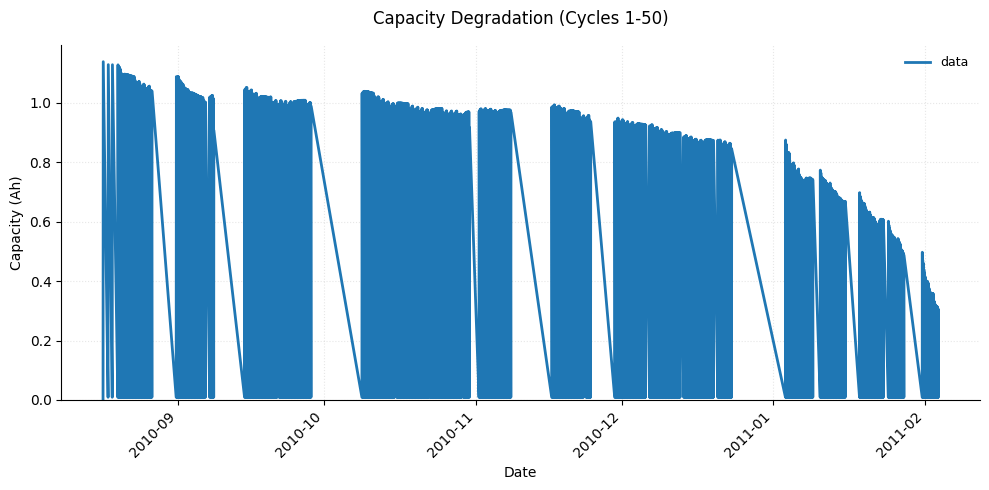

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Filter data for cycles 1-50
train_filtered = data[data['cycle'] <= 50]
val_filtered = data[data['cycle'] <= 50]
test_filtered = data[data['cycle'] <= 50]

# Aggregate by date
train_agg = data.groupby('Date_Time')['capacity'].mean().reset_index()


# Create minimalist figure
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

# Clean line plots (no fill, no markers)
ax.plot(train_agg['Date_Time'], train_agg['capacity'], 
        color='#1f77b4', linewidth=2, label='data')  # Blue


# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Format y-axis
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.set_ylim(bottom=0)  # Start y-axis at 0

# Add light grid
ax.grid(True, linestyle=':', alpha=0.3)

# Labels and title
ax.set_title('Capacity Degradation (Cycles 1-50)', pad=15, fontsize=12)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Capacity (Ah)', fontsize=10)

# Clean legend
ax.legend(frameon=False, fontsize=9)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


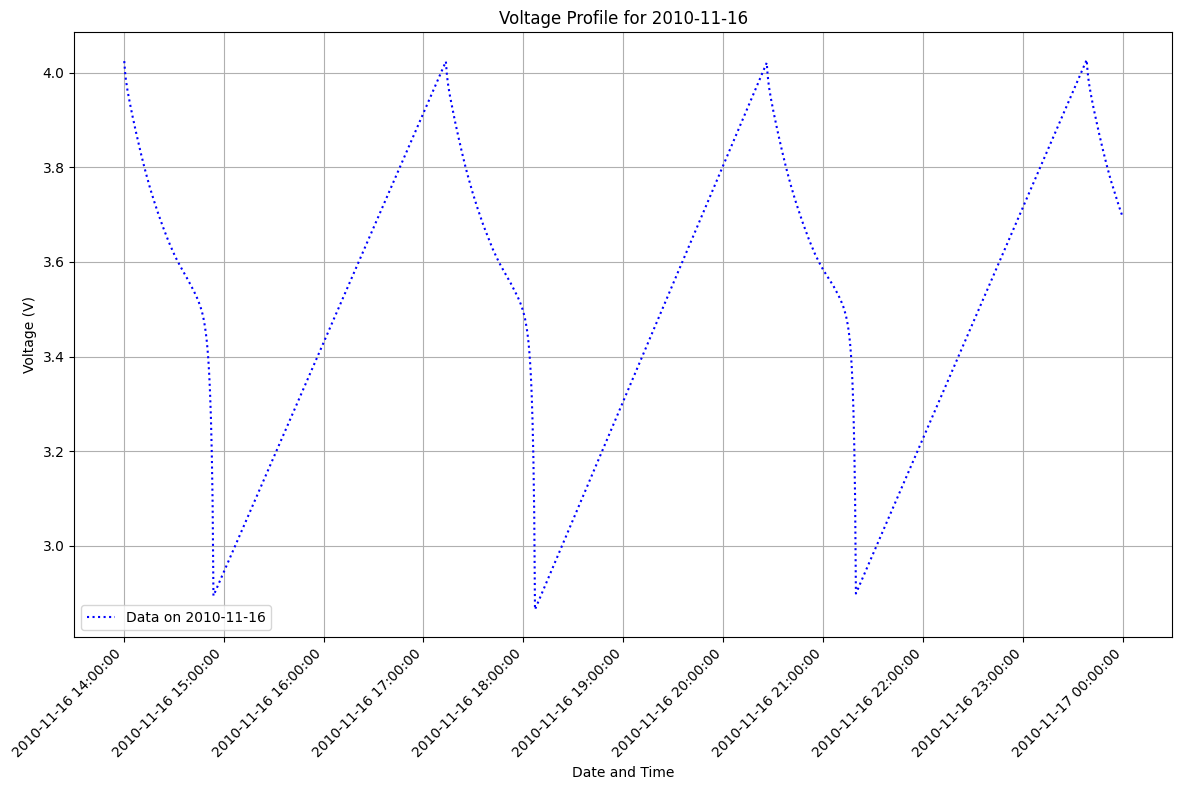

In [6]:
import matplotlib.pyplot as plt

# Filter the data for the specific date (2010-11-16)
specific_date = '2010-11-16'
filtered_data = data[data['Date_Time'].dt.date == pd.to_datetime(specific_date).date()]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot voltage data for the specific date
ax.plot(filtered_data['Date_Time'], filtered_data['voltage'], 'b:', label=f'Data on {specific_date}')

# Format the x-axis to show date and time
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Adjust the interval for better spacing
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Rotate the date labels for readability
plt.xticks(rotation=45, ha='right')

# Labels and title
ax.set(xlabel='Date and Time', ylabel='Voltage (V)',
       title=f'Voltage Profile for {specific_date}')

ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


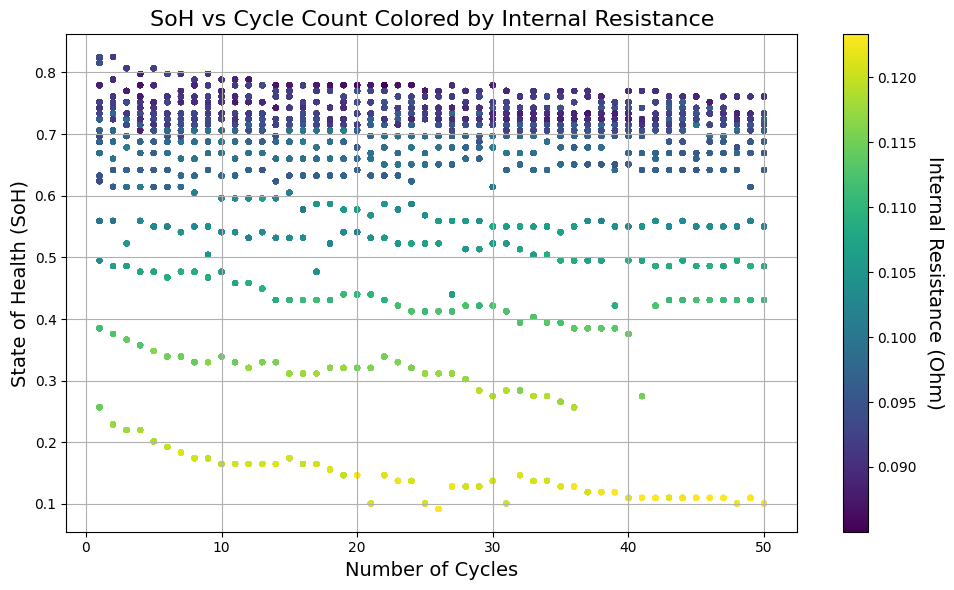

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine all data for unified visualization


# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['cycle'], data['SoH'],
                      c=data['resistance'], s=10, cmap='viridis')

# Colorbar for resistance
cbar = plt.colorbar(scatter)
cbar.set_label('Internal Resistance (Ohm)', fontsize=14, rotation=-90, labelpad=20)

# Labels
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('State of Health (SoH)', fontsize=14)
plt.title('SoH vs Cycle Count Colored by Internal Resistance', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


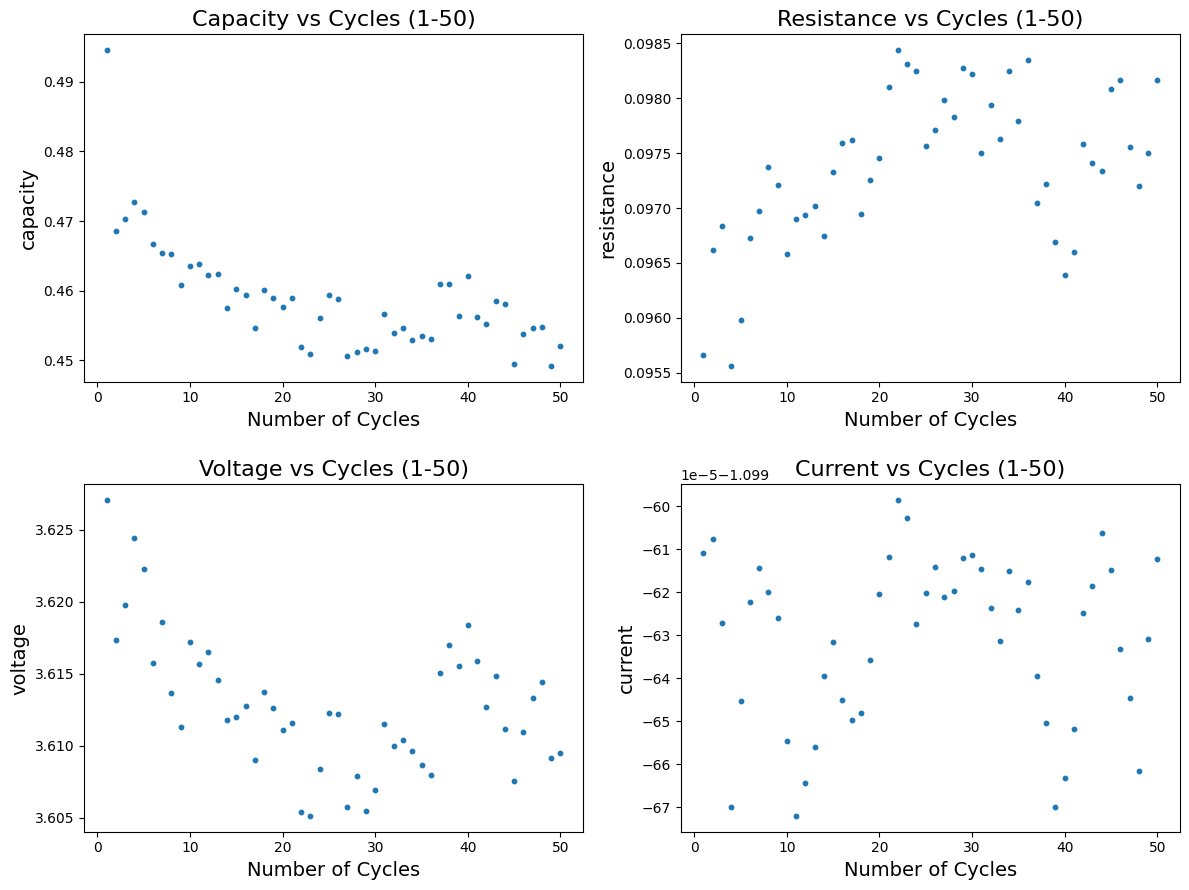

In [8]:
import matplotlib.pyplot as plt

# Aggregate data by cycle for each feature
aggregated_data = data.groupby('cycle')[['capacity', 'resistance', 'voltage', 'current']].mean().reset_index()

# Filter the data to only include cycles from 1 to 50
aggregated_data_filtered = aggregated_data[aggregated_data['cycle'] <= 50]

# Plotting
plt.figure(figsize=(12, 9))

names = ['capacity', 'resistance', 'voltage', 'current']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.scatter(aggregated_data_filtered['cycle'], aggregated_data_filtered[names[i]], s=10)
    plt.xlabel('Number of Cycles', fontsize=14)
    plt.ylabel(names[i], fontsize=14)
    plt.title(f'{names[i].capitalize()} vs Cycles (1-50)', fontsize=16)

plt.tight_layout()
plt.show()


In [9]:
# # Total dates from the dataset
# all_dates = pd.to_datetime(pd.concat([data['Date_Time']])).sort_values()

# split_idx = int(len(all_dates) * 0.75)  # Cut off last 25% entirely

# # 3. Split the "good" portion (first 75% of timeline)
# good_dates = all_dates[:split_idx]
# train_end = int(len(good_dates) * 0.60)  # 2/3 of good period for training
# val_end = int(len(good_dates) * 0.80)    # 1/6 of good period for validation

# # 4. Assign date ranges
# train_dates = good_dates[:train_end]      # First 50% of total timeline
# val_dates = good_dates[val_end:] # Next 12.5% 
# test_dates = good_dates[train_end:val_end]         # Following 12.5% (excludes last 25%)


# print(f"Training period (safe): {train_dates.min().date()} to {train_dates.max().date()}")
# print(f"Validation period (safe): {val_dates.min().date()} to {val_dates.max().date()}")
# print(f"Testing period (safe): {test_dates.min().date()} to {test_dates.max().date()}")
# print(f"\nExcluded problematic period: {all_dates[split_idx].date()} onward")


In [10]:
len(data_testval)

87237

In [11]:
# Ensure datetime columns are in datetime format
data['Date_Time'] = pd.to_datetime(data['Date_Time'])            # CS2_35 (Train + Val)
data_testval['Date_Time'] = pd.to_datetime(data_testval['Date_Time'])  # CS2_36 (Test)

# --- From CS2_35: Use only 75% for training + validation ---
cs2_35_dates = data['Date_Time'].sort_values()
subset_cutoff_idx = int(len(cs2_35_dates) * 0.75)
subset_dates = cs2_35_dates[:subset_cutoff_idx]
subset_data = data[data['Date_Time'].isin(subset_dates)]

# Now split this 75% portion into train and val (e.g., 80/20 split within that 75%)
train_cutoff_idx = int(len(subset_dates) * 0.7)
train_dates = subset_dates[:train_cutoff_idx]
val_dates = subset_dates[train_cutoff_idx:]

train_data = data[data['Date_Time'].isin(train_dates)]
val_data = data[data['Date_Time'].isin(val_dates)]

# --- From CS2_36: use only 40% for test ---
cs2_36_dates = data_testval['Date_Time'].sort_values()
test_cutoff_idx = int(len(cs2_36_dates) * 0.3)
test_dates = cs2_36_dates[:test_cutoff_idx]
test_data = data_testval[data_testval['Date_Time'].isin(test_dates)]

# --- Print summary ---
print(f"Total CS2_35 records used (75%): {len(subset_data)}")
print(f"Training data length (from CS2_35 75% * 80%): {len(train_data)}")
print(f"Validation data length (from CS2_35 75% * 20%): {len(val_data)}")
print(f"Testing data length (40% of CS2_36): {len(test_data)}")

print(f"Training period: {train_data['Date_Time'].min().date()} to {train_data['Date_Time'].max().date()}")
print(f"Validation period: {val_data['Date_Time'].min().date()} to {val_data['Date_Time'].max().date()}")
print(f"Testing period: {test_data['Date_Time'].min().date()} to {test_data['Date_Time'].max().date()}")


Total CS2_35 records used (75%): 65218
Training data length (from CS2_35 75% * 80%): 45652
Validation data length (from CS2_35 75% * 20%): 19566
Testing data length (40% of CS2_36): 26171
Training period: 2010-08-16 to 2010-11-07
Validation period: 2010-11-07 to 2010-12-17
Testing period: 2010-08-16 to 2010-09-25


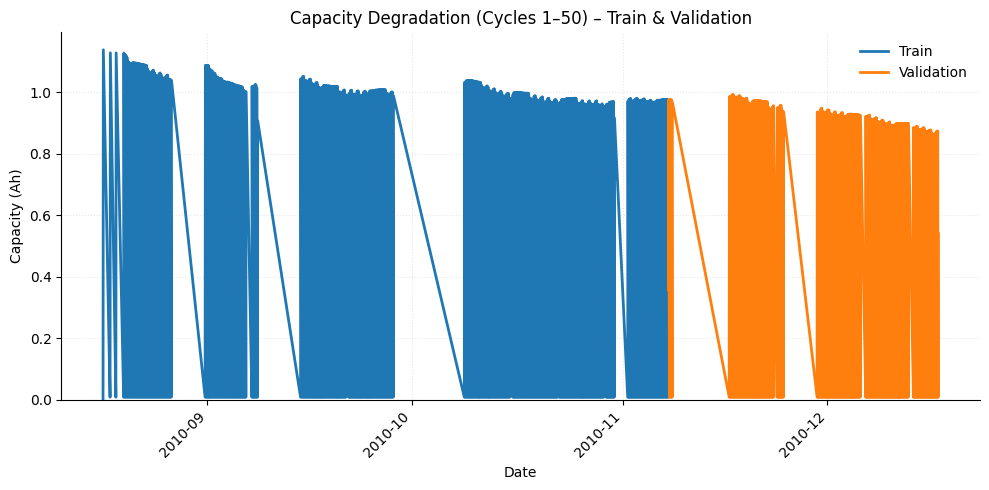

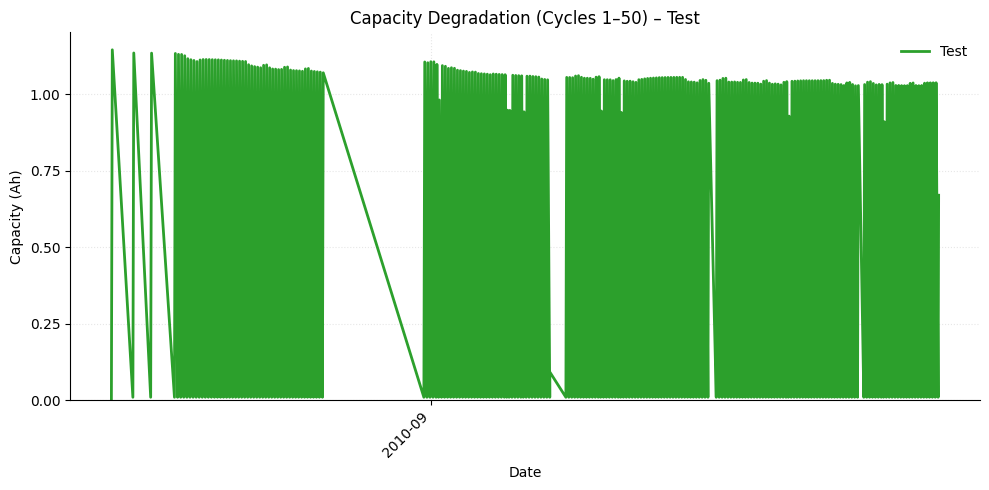

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Filter for cycles 1-50
train_filtered = train_data[train_data['cycle'] <= 50]
val_filtered = val_data[val_data['cycle'] <= 50]
test_filtered = test_data[test_data['cycle'] <= 50]

# Aggregate mean capacity by date
train_agg = train_filtered.groupby('Date_Time')['capacity'].mean().reset_index()
val_agg = val_filtered.groupby('Date_Time')['capacity'].mean().reset_index()
test_agg = test_filtered.groupby('Date_Time')['capacity'].mean().reset_index()

# --- Plot Train and Validation Together ---
plt.figure(figsize=(10, 5), tight_layout=True)
plt.plot(train_agg['Date_Time'], train_agg['capacity'], color='#1f77b4', linewidth=2, label='Train')      # blue
plt.plot(val_agg['Date_Time'], val_agg['capacity'], color='#ff7f0e', linewidth=2, label='Validation')    # orange

plt.title('Capacity Degradation (Cycles 1–50) – Train & Validation', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Capacity (Ah)', fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(6))
plt.ylim(bottom=0)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# --- Plot for Test Data Only ---
plt.figure(figsize=(10, 5), tight_layout=True)
plt.plot(test_agg['Date_Time'], test_agg['capacity'], color='#2ca02c', linewidth=2, label='Test')  # green

plt.title('Capacity Degradation (Cycles 1–50) – Test', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Capacity (Ah)', fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(6))
plt.ylim(bottom=0)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


In [13]:
train_data_f = train_data[['voltage', 'current', 'resistance', 'capacity']]
val_data_f = val_data[['voltage', 'current', 'resistance', 'capacity']]
test_data_f = test_data[['voltage', 'current', 'resistance', 'capacity']]

In [14]:
# import matplotlib.pyplot as plt

# # Set the plotting style
# plt.style.use('seaborn-v0_8-darkgrid')

# # Define a function to plot features
# def plot_features(df, title):
#     fig, axs = plt.subplots(len(df.columns), 1, figsize=(12, 10), sharex=True)
#     fig.suptitle(title, fontsize=16)
    
#     for i, column in enumerate(df.columns):
#         axs[i].plot(df[column].values)
#         axs[i].set_ylabel(column)
    
#     axs[-1].set_xlabel('Sample Index')
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

# # Plot each dataset
# plot_features(data, "Training Data Features")


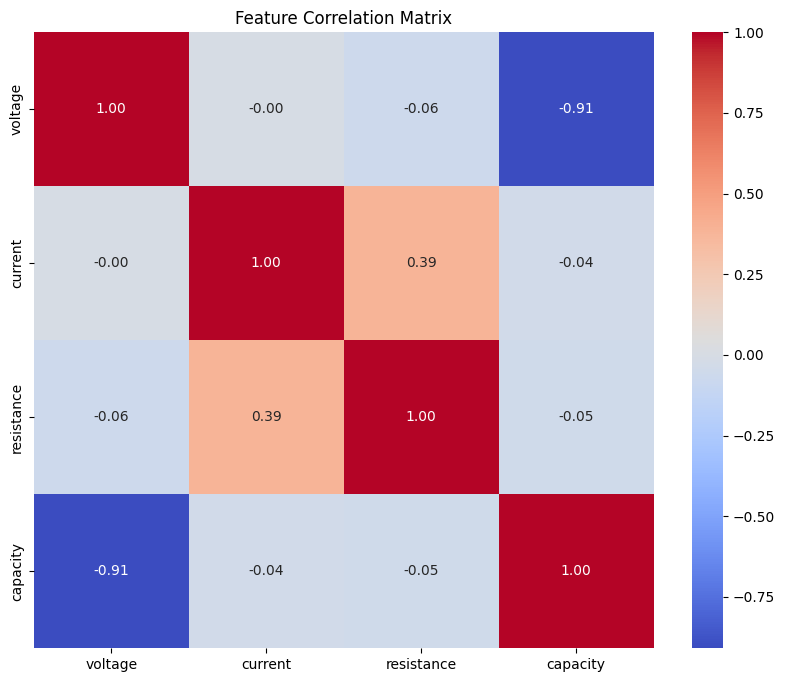

In [15]:
# Compute correlations
import seaborn as sns
correlation_matrix = train_data_f.corr()



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

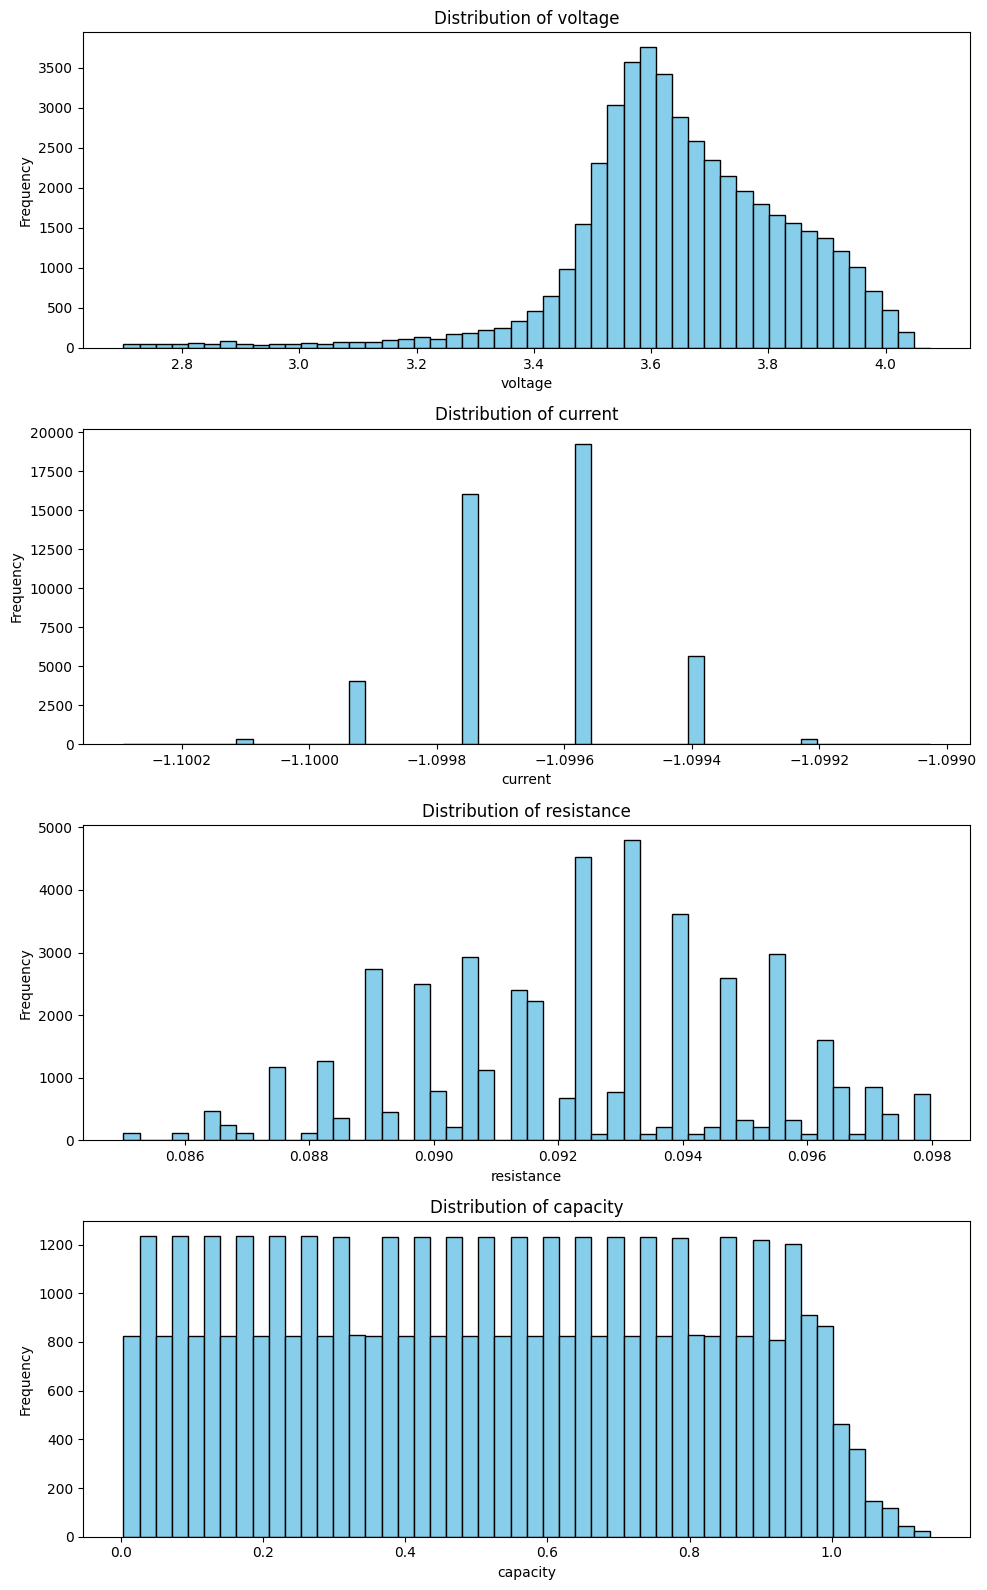

In [16]:
import matplotlib.pyplot as plt

# List of features to plot (excluding 'Cycle_Index')
selected_features = train_data_f.columns

# Adjust figure size depending on number of features
plt.figure(figsize=(10, 4 * len(selected_features)))  # Dynamic height

for i, feature in enumerate(selected_features, 1):
    plt.subplot(len(selected_features), 1, i)
    plt.hist(train_data[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [17]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd



# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the training, validation, and testing data (only the selected features)
train_data_scaled = scaler.fit_transform(train_data_f)
val_data_scaled = scaler.transform(val_data_f)
test_data_scaled = scaler.transform(test_data_f)


print(type(train_data_scaled))



<class 'numpy.ndarray'>


In [18]:
import numpy as np

sequence_length = 67

# Function to create sequences with the shape (samples, 4, 67)
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # The new sequence should have 4 features and 67 timesteps
        X.append(data[i:i + sequence_length].T)  # Transpose the sequence: (4, 67)
        y.append(data[i + sequence_length, 0])  # You can select the first feature or any other feature for the target
    return np.array(X), np.array(y)

# Assuming train_data_scaled, val_data_scaled, and test_data_scaled have shape (samples, 4)
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_val, y_val = create_sequences(val_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Check the shapes
print("X_train shape:", X_train.shape)  # Should print (50035, 4, 67)
print("y_train shape:", y_train.shape)  # Should print (50035, )
print("X_val shape:", X_val.shape)      # Should print (3181, 4, 67)
print("y_val shape:", y_val.shape)      # Should print (3181, )
print("X_test shape:", X_test.shape)    # Should print (16439, 4, 67)
print("y_test shape:", y_test.shape)    # Should print (16439, )


X_train shape: (45585, 4, 67)
y_train shape: (45585,)
X_val shape: (19499, 4, 67)
y_val shape: (19499,)
X_test shape: (26104, 4, 67)
y_test shape: (26104,)


In [19]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [20]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batching
batch_size = 512 # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 67, 1]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection

Batch x shape: torch.Size([512, 4, 67])
Batch y shape: torch.Size([512])


### GRU MODEL

In [21]:
# from torch.nn import GRU
# GRU_model.net = GRU(6, 128, num_layers=2, batch_first=True)

In [22]:
def calculate_metrics_sklearn(y_true, y_pred):
    """Calculate R², MAE, MSE, and MAPE using sklearn metrics."""
    # R²
    r2 = r2_score(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    # mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Multiply by 100 to get percentage

    return r2, mae, mse

def Train(model, train_loader, valid_loader, test_loader, args, save_folder=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Ensure the model is on the correct device

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    # Define loss function
    mse_loss = torch.nn.MSELoss()

    min_loss = 10
    stop = 0
    train_losses = []
    valid_losses = []
    best_state = None

    # Store metrics for train, validation, and test
    train_r2_values = []
    valid_r2_values = []

    for e in range(1, args.n_epoch + 1):
        # --------- Train one epoch manually ---------
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            # print("Data batch shape:", data.shape)  # Should be [512, ...]
            # print("Label batch shape:", label.shape)
            pred = model(data)
            # print("Predicted shape:", pred.shape)
            # print("Target shape:", label.shape)
            loss = mse_loss(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(pred.cpu().detach().numpy())
            all_train_labels.append(label.cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Calculate metrics for training
        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
        train_r2, train_mae,train_mse = calculate_metrics_sklearn(all_train_labels, all_train_preds)
        train_r2_values.append(train_r2)

        scheduler.step()

        # --------- Validation manually ---------
        model.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)
                label = label.unsqueeze(1)
                pred = model(data)
                loss = mse_loss(pred, label)
                valid_loss += loss.item()

                all_valid_preds.append(pred.cpu().detach().numpy())
                all_valid_labels.append(label.cpu().detach().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Calculate metrics for validation
        all_valid_preds = np.concatenate(all_valid_preds, axis=0)
        all_valid_labels = np.concatenate(all_valid_labels, axis=0)
        valid_r2, valid_mae, valid_mse = calculate_metrics_sklearn(all_valid_labels, all_valid_preds)
        valid_r2_values.append(valid_r2)

        lr = optimizer.state_dict()['param_groups'][0]['lr']
        
        # Print each epoch's training and validation results
        print(f"Epoch [{e}/{args.n_epoch}] - Train Loss: {train_loss:.5f} | Train R²: {train_r2:.5f} | Train MAE: {train_mae:.5f} | Train MSE: {train_mse:.5f}")
        print(f"             - Valid Loss: {valid_loss:.5f} | Valid R²: {valid_r2:.5f} | Valid MAE: {valid_mae:.5f} | Valid MSE: {valid_mse:.5f}")
    
        
        if e % 10 == 0:
            print()  # Newline every 10 epochs for clarity
        delta = 1e-3 
        # --------- Save best model ---------
        if valid_loss < min_loss - delta:
            best_state = model.state_dict()
            min_loss = valid_loss
            stop = 0
        else: stop += 1
        # --------- Early stopping ---------
        if stop >= args.early_stop:
            print("\nEarly stopping triggered.")
            break

    # --------- After all epochs, evaluate on test set ---------
    test_loss = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)
            test_loss += loss.item()

            all_test_preds.append(pred.cpu().detach().numpy())
            all_test_labels.append(label.cpu().detach().numpy())

    test_loss /= len(test_loader)

    # Flatten the predictions and labels for metric calculations
    all_test_preds = np.concatenate(all_test_preds, axis=0)
    all_test_labels = np.concatenate(all_test_labels, axis=0)
    
    # Calculate metrics for test set
    test_r2, test_mae, test_mse = calculate_metrics_sklearn(all_test_labels, all_test_preds)

    # Print test results at the end of training
    print(f"Final Test Loss: {test_loss:.5f}, Test R²: {test_r2:.5f}, Test MAE: {test_mae:.5f}, Test MSE: {test_mse:.5f}")

    # --------- Save model ---------
    # if save_folder is not None and best_state is not None:
    #     torch.save(best_state, save_folder + '/best_model.pth')

    return train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds


In [23]:

PATH = 'GRU_model.pth'  # Path to the saved weights
GRU_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

GRU_model =GRU_model.backbone
GRU_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRU_model.to(device)  # Move the model to the device

GRU(
  (net): GRU(4, 128, num_layers=2, batch_first=True)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [24]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 ,all_test_labels, all_test_preds = Train(GRU_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.02464 | Train R²: -0.29521 | Train MAE: 0.11712 | Train MSE: 0.02481
             - Valid Loss: 0.02143 | Valid R²: -0.10317 | Valid MAE: 0.11144 | Valid MSE: 0.02178
Epoch [2/100] - Train Loss: 0.01918 | Train R²: -0.00730 | Train MAE: 0.10231 | Train MSE: 0.01929
             - Valid Loss: 0.02047 | Valid R²: -0.05206 | Valid MAE: 0.10814 | Valid MSE: 0.02077
Epoch [3/100] - Train Loss: 0.01567 | Train R²: 0.17515 | Train MAE: 0.08791 | Train MSE: 0.01580
             - Valid Loss: 0.01514 | Valid R²: 0.22596 | Valid MAE: 0.08808 | Valid MSE: 0.01528
Epoch [4/100] - Train Loss: 0.00992 | Train R²: 0.47627 | Train MAE: 0.05247 | Train MSE: 0.01003
             - Valid Loss: 0.01148 | Valid R²: 0.41918 | Valid MAE: 0.07360 | Valid MSE: 0.01147
Epoch [5/100] - Train Loss: 0.00831 | Train R²: 0.56136 | Train MAE: 0.04027 | Train MSE: 0.00840
             - Valid Loss: 0.01065 | Valid R²: 0.46201 | Valid MAE: 0.06997 | Valid MSE: 0.01062
Epoch [6/100] - Train

In [25]:
gru_calce_loss=test_loss
gru_calce_r2=test_r2

%store gru_calce_r2
%store gru_calce_loss

Stored 'gru_calce_r2' (float)
Stored 'gru_calce_loss' (float)


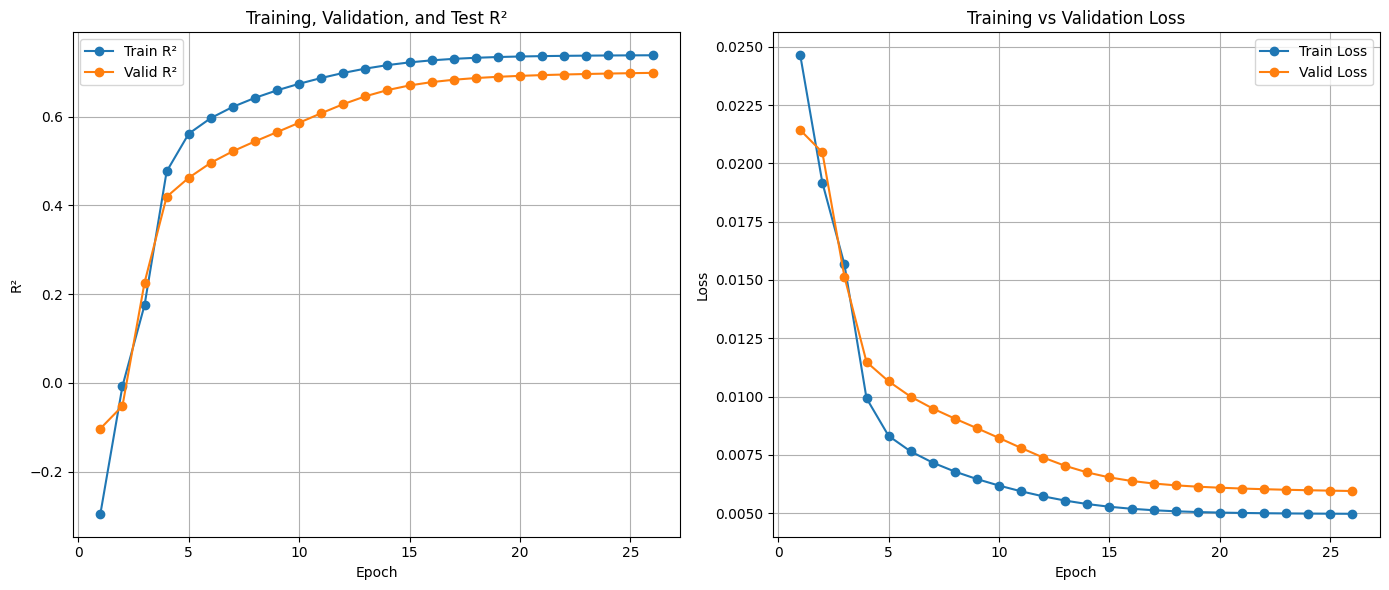

In [26]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### MLP MODEL

In [27]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

sequence_length = 128

# Function to create sequences with the shape (samples, 4, 67)
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # The new sequence should have 4 features and 67 timesteps
        X.append(data[i:i + sequence_length].T)  # Transpose the sequence: (4, 67)
        y.append(data[i + sequence_length, 0])  # You can select the first feature or any other feature for the target
    return np.array(X), np.array(y)

# Assuming train_data_scaled, val_data_scaled, and test_data_scaled have shape (samples, 4)
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_val, y_val = create_sequences(val_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Check the shapes
print("X_train shape:", X_train.shape)  # Should print (50035, 4, 67)
print("y_train shape:", y_train.shape)  # Should print (50035, )
print("X_val shape:", X_val.shape)      # Should print (3181, 4, 67)
print("y_val shape:", y_val.shape)      # Should print (3181, )
print("X_test shape:", X_test.shape)    # Should print (16439, 4, 67)
print("y_test shape:", y_test.shape)    # Should print (16439, )

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  # Change batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 4, 67]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection


X_train shape: (45524, 4, 128)
y_train shape: (45524,)
X_val shape: (19438, 4, 128)
y_val shape: (19438,)
X_test shape: (26043, 4, 128)
y_test shape: (26043,)
Batch x shape: torch.Size([128, 4, 128])
Batch y shape: torch.Size([128])


In [28]:

PATH = 'MLP_model.pth'  # Path to the saved weights
MLP_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

MLP_model =MLP_model.backbone
MLP_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_model.to(device)  # Move the model to the device

MLP(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  )
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [29]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(MLP_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.01219 | Train R²: 0.36251 | Train MAE: 0.06317 | Train MSE: 0.01220
             - Valid Loss: 0.01289 | Valid R²: 0.34583 | Valid MAE: 0.07212 | Valid MSE: 0.01289
Epoch [2/100] - Train Loss: 0.00834 | Train R²: 0.56372 | Train MAE: 0.04524 | Train MSE: 0.00835
             - Valid Loss: 0.01227 | Valid R²: 0.37747 | Valid MAE: 0.06949 | Valid MSE: 0.01227
Epoch [3/100] - Train Loss: 0.00750 | Train R²: 0.60777 | Train MAE: 0.04305 | Train MSE: 0.00751
             - Valid Loss: 0.01110 | Valid R²: 0.43684 | Valid MAE: 0.06107 | Valid MSE: 0.01110
Epoch [4/100] - Train Loss: 0.00697 | Train R²: 0.63527 | Train MAE: 0.04145 | Train MSE: 0.00698
             - Valid Loss: 0.00994 | Valid R²: 0.49560 | Valid MAE: 0.05441 | Valid MSE: 0.00994
Epoch [5/100] - Train Loss: 0.00647 | Train R²: 0.66180 | Train MAE: 0.03997 | Train MSE: 0.00647
             - Valid Loss: 0.00927 | Valid R²: 0.52967 | Valid MAE: 0.05836 | Valid MSE: 0.00927
Epoch [6/100] - Train Los

In [30]:
mlp_calce_loss=test_loss
mlp_calce_r2=test_r2

%store mlp_calce_r2
%store mlp_calce_loss

Stored 'mlp_calce_r2' (float)
Stored 'mlp_calce_loss' (float)


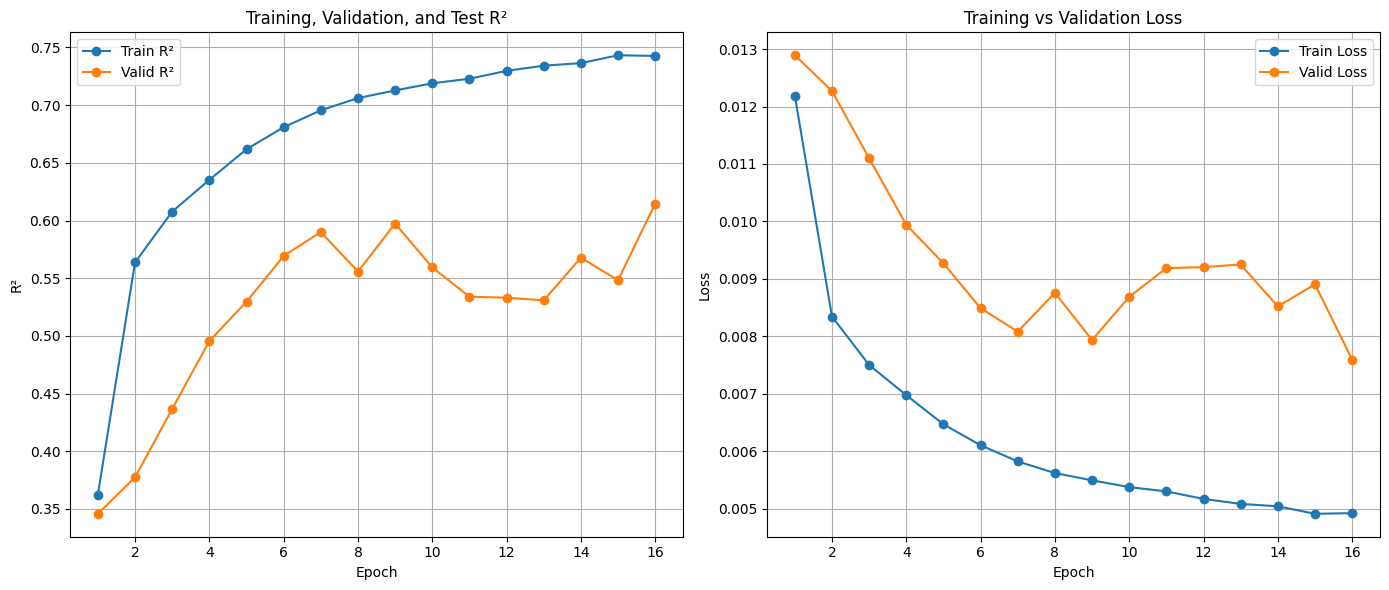

In [31]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### ATTENTİON MODEL

In [32]:

PATH = 'Attention_model.pth'  # Path to the saved weights
ATTENTİON_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)
ATTENTİON_model =ATTENTİON_model.backbone

# Set the model to evaluation mode
ATTENTİON_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ATTENTİON_model.to(device)  # Move the model to the device

Attention(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (l

In [33]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(ATTENTİON_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.01125 | Train R²: 0.41159 | Train MAE: 0.05874 | Train MSE: 0.01126
             - Valid Loss: 0.01190 | Valid R²: 0.39591 | Valid MAE: 0.06074 | Valid MSE: 0.01190
Epoch [2/100] - Train Loss: 0.00707 | Train R²: 0.63032 | Train MAE: 0.03932 | Train MSE: 0.00708
             - Valid Loss: 0.00981 | Valid R²: 0.50236 | Valid MAE: 0.04886 | Valid MSE: 0.00981
Epoch [3/100] - Train Loss: 0.00567 | Train R²: 0.70332 | Train MAE: 0.03323 | Train MSE: 0.00568
             - Valid Loss: 0.00969 | Valid R²: 0.50828 | Valid MAE: 0.06561 | Valid MSE: 0.00969
Epoch [4/100] - Train Loss: 0.00495 | Train R²: 0.74110 | Train MAE: 0.02984 | Train MSE: 0.00496
             - Valid Loss: 0.00885 | Valid R²: 0.55091 | Valid MAE: 0.06074 | Valid MSE: 0.00885
Epoch [5/100] - Train Loss: 0.00479 | Train R²: 0.74957 | Train MAE: 0.03019 | Train MSE: 0.00479
             - Valid Loss: 0.01051 | Valid R²: 0.46680 | Valid MAE: 0.07584 | Valid MSE: 0.01051
Epoch [6/100] - Train Los

In [34]:
att_calce_loss=test_loss
att_calce_r2=test_r2

%store att_calce_r2
%store att_calce_loss

Stored 'att_calce_r2' (float)
Stored 'att_calce_loss' (float)


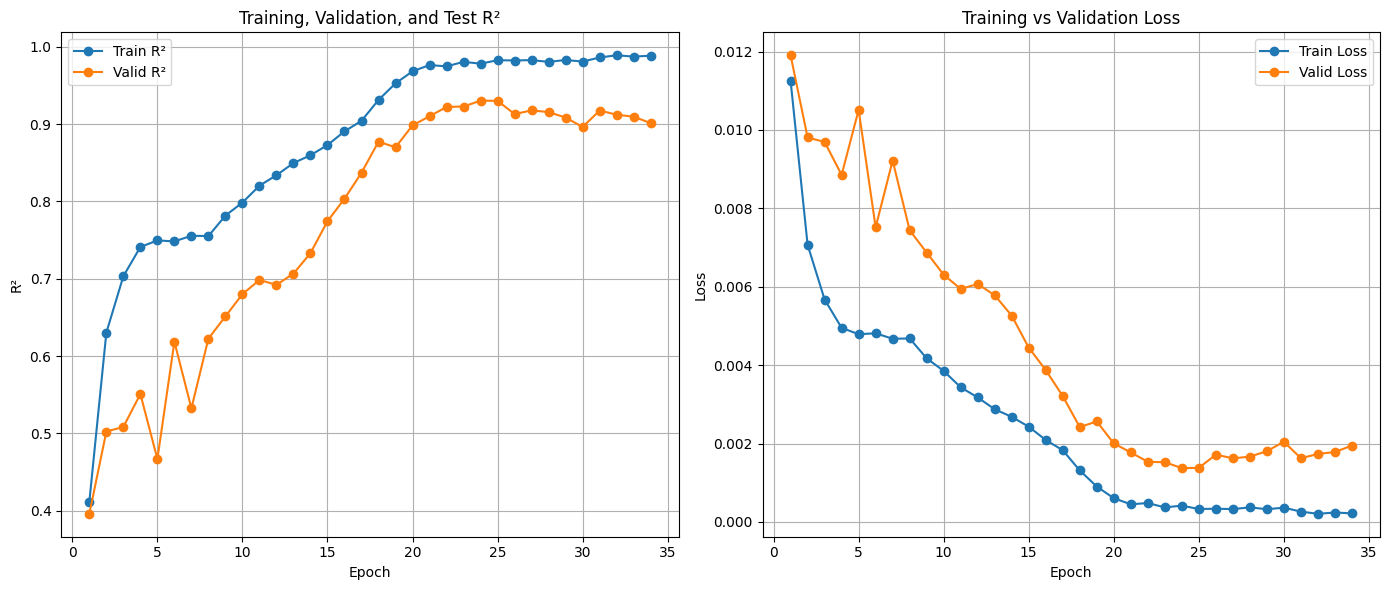

In [35]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### CNN MODEL

In [36]:

PATH = 'CNN_model.pth'  # Path to the saved weights
CNN_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)
CNN_model =CNN_model.backbone

# Set the model to evaluation mode
CNN_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CNN_model.to(device)  # Move the model to the device

CNN(
  (layer1): ResBlock(
    (conv): Sequential(
      (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip_connection): Sequential(
      (0): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (layer2): ResBlock(
    (conv): Sequential(
      (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [37]:
# for name, param in CNN_model.named_parameters():
#     if all(x not in name for x in ['predictor', 'layer4', 'layer5','layer3',]):
#         param.requires_grad = False  # Freeze everything else
#     else:
#         param.requires_grad = True   # Unfreeze predictor, layer4, layer5


In [38]:
# for name, param in CNN_model.named_parameters():
#     status = "Trainable" if param.requires_grad else "Frozen"
#     print(f"{name}: {status}")

In [39]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(CNN_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.00480 | Train R²: 0.74902 | Train MAE: 0.03393 | Train MSE: 0.00480
             - Valid Loss: 0.09153 | Valid R²: -3.64223 | Valid MAE: 0.23631 | Valid MSE: 0.09148
Epoch [2/100] - Train Loss: 0.00188 | Train R²: 0.90165 | Train MAE: 0.01999 | Train MSE: 0.00188
             - Valid Loss: 0.01027 | Valid R²: 0.47868 | Valid MAE: 0.07063 | Valid MSE: 0.01027
Epoch [3/100] - Train Loss: 0.00083 | Train R²: 0.95636 | Train MAE: 0.01303 | Train MSE: 0.00084
             - Valid Loss: 0.00914 | Valid R²: 0.53636 | Valid MAE: 0.05704 | Valid MSE: 0.00914
Epoch [4/100] - Train Loss: 0.00064 | Train R²: 0.96632 | Train MAE: 0.01119 | Train MSE: 0.00064
             - Valid Loss: 0.01322 | Valid R²: 0.32944 | Valid MAE: 0.06970 | Valid MSE: 0.01321
Epoch [5/100] - Train Loss: 0.00056 | Train R²: 0.97089 | Train MAE: 0.01023 | Train MSE: 0.00056
             - Valid Loss: 0.01239 | Valid R²: 0.37132 | Valid MAE: 0.06752 | Valid MSE: 0.01239
Epoch [6/100] - Train Lo

In [40]:
cnn_calce_loss=test_loss
cnn_calce_r2=test_r2

%store cnn_calce_r2
%store cnn_calce_loss

Stored 'cnn_calce_r2' (float)
Stored 'cnn_calce_loss' (float)


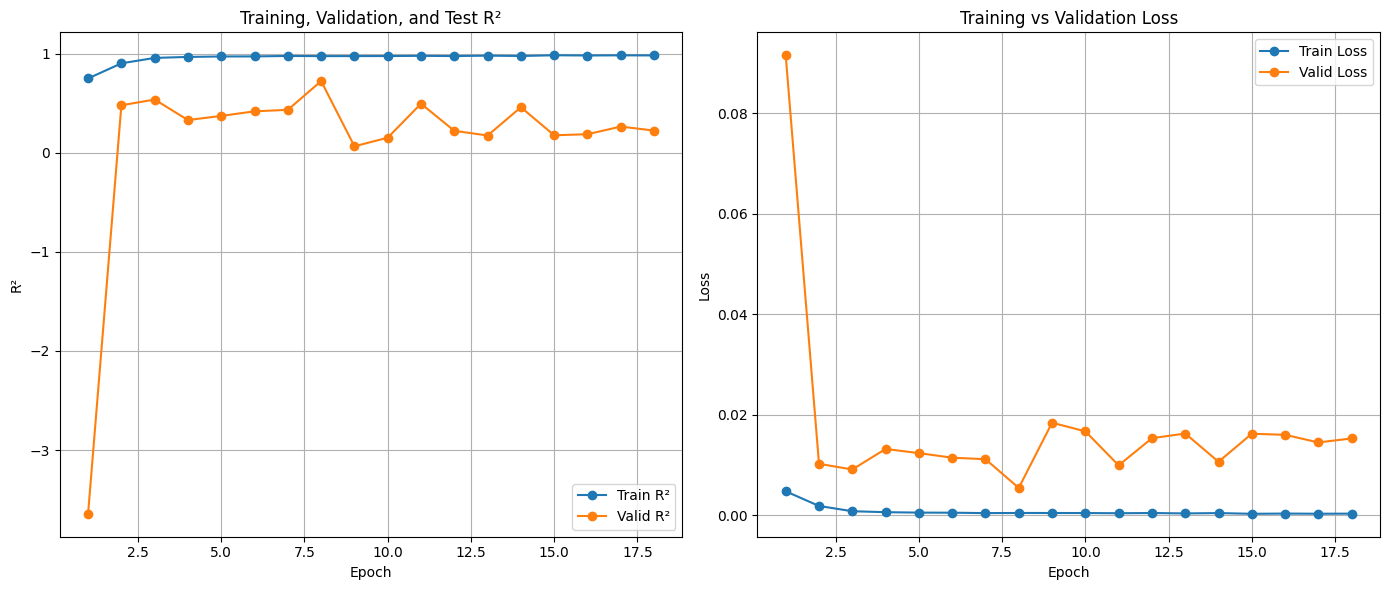

In [41]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### LSTM MODEL

In [42]:
PATH = 'LSTM_model.pth'  # Path to the saved weights
LSTM_model = torch.load(PATH, map_location=torch.device('cpu'), weights_only=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LSTM_model.to(device)  # Move the model to the device

LSTM_model =LSTM_model.backbone

# Set the model to evaluation mode
LSTM_model.eval()


LSTM(
  (net): LSTM(4, 128, num_layers=2, batch_first=True)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [43]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(LSTM_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.01418 | Train R²: 0.25838 | Train MAE: 0.07336 | Train MSE: 0.01419
             - Valid Loss: 0.01208 | Valid R²: 0.38685 | Valid MAE: 0.05401 | Valid MSE: 0.01208
Epoch [2/100] - Train Loss: 0.00926 | Train R²: 0.51577 | Train MAE: 0.04292 | Train MSE: 0.00927
             - Valid Loss: 0.00840 | Valid R²: 0.57381 | Valid MAE: 0.03790 | Valid MSE: 0.00840
Epoch [3/100] - Train Loss: 0.00686 | Train R²: 0.64107 | Train MAE: 0.03137 | Train MSE: 0.00687
             - Valid Loss: 0.00708 | Valid R²: 0.64060 | Valid MAE: 0.03428 | Valid MSE: 0.00708
Epoch [4/100] - Train Loss: 0.00600 | Train R²: 0.68634 | Train MAE: 0.02931 | Train MSE: 0.00600
             - Valid Loss: 0.00662 | Valid R²: 0.66436 | Valid MAE: 0.03703 | Valid MSE: 0.00661
Epoch [5/100] - Train Loss: 0.00534 | Train R²: 0.72050 | Train MAE: 0.02818 | Train MSE: 0.00535
             - Valid Loss: 0.00635 | Valid R²: 0.67778 | Valid MAE: 0.03971 | Valid MSE: 0.00635
Epoch [6/100] - Train Los

In [44]:
lstm_calce_loss=test_loss
lstm_calce_r2=test_r2

%store lstm_calce_r2
%store lstm_calce_loss

Stored 'lstm_calce_r2' (float)
Stored 'lstm_calce_loss' (float)


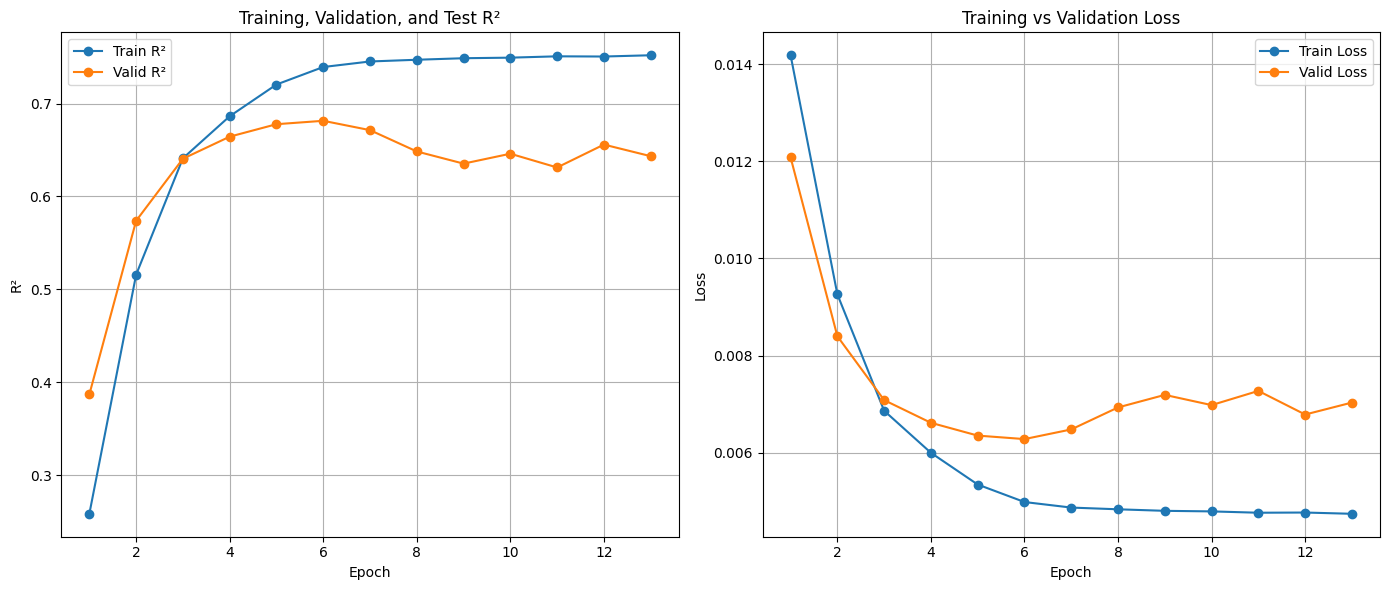

In [45]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
